In [1]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import fmax as fm
import numpy as np

In [30]:
def plot_posterior_predictive(fcast_model, label):
    """Simple plot of the posterior predictive of a forecast model.
    """

    sample_paths = fcast_model.posterior_predictive_samples
    index = fcast_model.train_index

    # Calculate the 1%, 10%, 50%, 90%, and 99% quantiles
    lower_bound_one = np.quantile(sample_paths, q=0.01, axis=0)
    lower_bound_ten = np.quantile(sample_paths, q=0.1, axis=0)
    medians = np.quantile(sample_paths, q=0.5, axis=0)
    upper_bound_ninety = np.quantile(sample_paths, q=0.9, axis=0)
    upper_bound_ninety_nine = np.quantile(sample_paths, q=0.99, axis=0)

    # Plot
    fig, axs = plt.subplots(figsize=(13,8))

    axs.fill_between(index, lower_bound_one, upper_bound_ninety_nine, alpha=0.4, label="99% CI", color="C0")
    axs.fill_between(index, lower_bound_ten, upper_bound_ninety, alpha=0.7, label="80% CI", color="C0")
    axs.plot(index, medians, label="Median")
    axs.plot(index, fcast_model.train_data, color="red", label="Training")
    axs.legend()
    axs.set_xlabel("Period")
    axs.set_ylabel("Record")
    axs.set_title(label)

    fig.tight_layout()

    return fig

In [43]:
def plot_forecast(fcast_model, test_data, label, actual):
    """Simple plot of the posterior predictive of a forecast model.
    """

    sample_paths = fcast_model.forecast_samples
    index = fcast_model.master_with_fcast_index

    # Calculate the 1%, 10%, 50%, 90%, and 99% quantiles
    lower_bound_one = np.quantile(sample_paths, q=0.01, axis=0)
    lower_bound_ten = np.quantile(sample_paths, q=0.1, axis=0)
    medians = np.quantile(sample_paths, q=0.5, axis=0)
    upper_bound_ninety = np.quantile(sample_paths, q=0.9, axis=0)
    upper_bound_ninety_nine = np.quantile(sample_paths, q=0.99, axis=0)

    # Plot
    fig, axs = plt.subplots(figsize=(13,8))
    
    axs.fill_between(index, lower_bound_one, upper_bound_ninety_nine, alpha=0.4, label="99% CI", color="C0")
    axs.fill_between(index, lower_bound_ten, upper_bound_ninety, alpha=0.7, label="80% CI", color="C0")
    axs.plot(index, medians, label="Median")
    axs.plot(fcast_model.train_index, fcast_model.train_data, color="red", label="Training")
    axs.plot(fcast_model.fcast_index, test_data, color="black", label="Tryfos")
    axs.plot(fcast_model.fcast_index, actual, color="green", label="Actual")
    axs.legend()
    axs.set_xlabel("Period")
    axs.set_ylabel("Record")
    axs.set_title(label)

    fig.tight_layout()

    return fig

# Gaussian

In [44]:
whiches = ["1000m", "1m", "5000m", "Marathon"]
for which in whiches:
  df = pd.read_csv("tryfos_data.csv")
  years, records = df["Year"].values, df[which].values # Years 1983 and onward are just forecasts

  training_years = years[:15]
  training_records = records[:15]
  tryfos_years = years[15:]
  tryfos_fcast = records[15:]

  prior_parameters = {
            'mu' : {
              'mean' : training_records[0],
              'std' : 0.05*training_records[0],
            },
            'sigma' : {
              'lam' : 1
            }
          }

  model = fm.NewForecastModel(training_records, prior_parameters=prior_parameters, attempt_distribution="gaussian", kind="min", train='all', fcast_len=len(tryfos_fcast))
  model.fit(chains=1)
  model.posterior_predictive()
  model.forecast()
  
  actual_df = pd.read_csv("tryfos_actual.csv")
  _, actual_records = actual_df["Year"].values, actual_df[which].values

  fig = plot_posterior_predictive(model, f"{which}, Gaussian Attempts, Posterior Predictive")
  fig.savefig(f"{which}_gaussian_attempts_post_pred.png")

  fig = plot_forecast(model, tryfos_fcast, f"{which}, Gaussian Attempts, Forecast", actual_records)
  fig.savefig(f"{which}_gaussian_attempts_forecast.png")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


# Gumbel

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 20_000 tune and 40_000 draw iterations (20_000 + 40_000 draws total) took 80 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 20_000 tune and 40_000 draw iterations (20_000 + 40_000 draws total) took 73 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 20_000 tune and 40_000 draw iterations (20_000 + 40_000 draws total) took 81 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu': array(-7777.), 'sigma_log__': array(-0.36651292)}

Initial evaluation results:
mu            -6.88
sigma_log__   -1.06
running_max    -inf
Name: Log-probability of test_point, dtype: float64

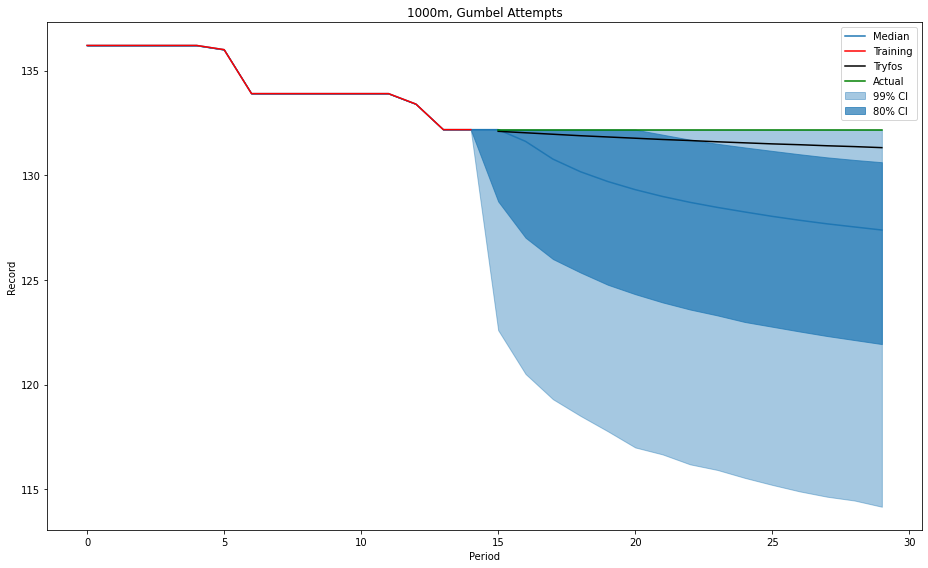

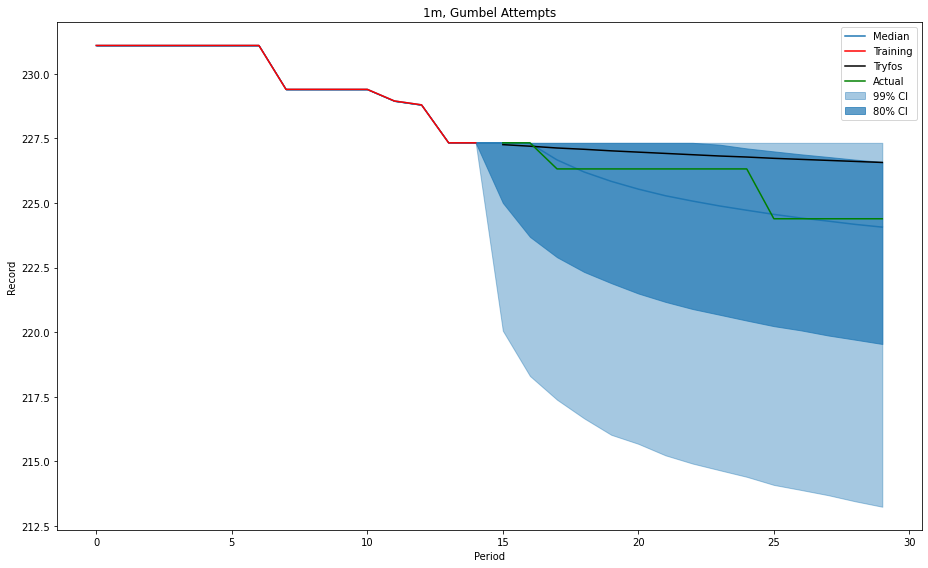

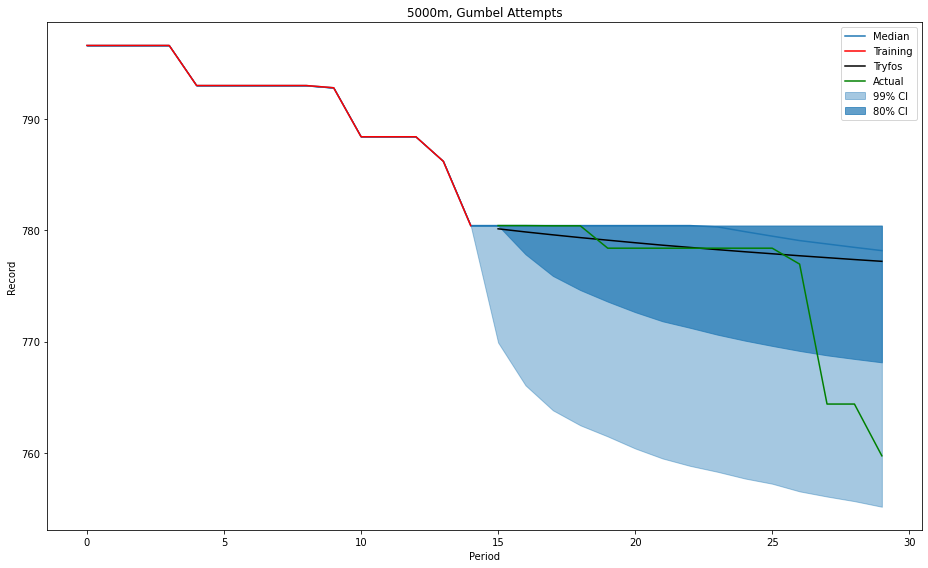

In [5]:
whiches = ["1000m", "1m", "5000m", "Marathon"]
#whiches = ["1000m"]
for which in whiches:
    df = pd.read_csv("tryfos_data.csv")
    years, records = df["Year"].values, df[which].values # Years 1983 and onward are just forecasts

    training_years = years[:15]
    training_records = records[:15]
    tryfos_years = years[15:]
    tryfos_fcast = records[15:]

    model = fm.ForecastModel(training_records, kind="min", train='all', fcast_len=len(tryfos_fcast), attempts="gumbel")
    model.fit(attempts_mean_mu=-training_records[0], attempts_mean_sigma=0.05*training_records[0], attempts_stdev_lam=1, chains=1, draws=40000, tune=20000)

    model.draw_forecasts()

    actual_df = pd.read_csv("tryfos_actual.csv")
    _, actual_records = actual_df["Year"].values, actual_df[which].values

    fig = plot_posterior_predictive(model, tryfos_fcast, f"{which}, Gumbel Attempts", actual_records)
    fig.savefig(f"{which}_gumbel_attempts.png")

In [6]:
whiches = ["Marathon"]
#whiches = ["1000m"]
for which in whiches:
    df = pd.read_csv("tryfos_data.csv")
    years, records = df["Year"].values, df[which].values # Years 1983 and onward are just forecasts

    training_years = years[:15]
    training_records = records[:15]
    tryfos_years = years[15:]
    tryfos_fcast = records[15:]

    model = fm.ForecastModel(training_records, kind="min", train='all', fcast_len=len(tryfos_fcast), attempts="gumbel")
    model.fit(attempts_mean_mu=-training_records[0], attempts_mean_sigma=0.05*training_records[0], attempts_stdev_lam=1, chains=1, draws=40000, tune=20000)

    model.draw_forecasts()

    actual_df = pd.read_csv("tryfos_actual.csv")
    _, actual_records = actual_df["Year"].values, actual_df[which].values

    fig = plot_posterior_predictive(model, tryfos_fcast, f"{which}, Gumbel Attempts", actual_records)
    fig.savefig(f"{which}_gumbel_attempts.png")

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu': array(-7777.), 'sigma_log__': array(-0.36651292)}

Initial evaluation results:
mu            -6.88
sigma_log__   -1.06
running_max    -inf
Name: Log-probability of test_point, dtype: float64

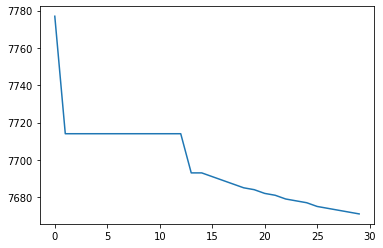

In [7]:
plt.plot(records)

In [4]:
def gumbel_attempts_min(jump_data, flat_data, mu, sigma):
    """Log likelihood with a Gumbel attempt distribution.
    """

    beta = (1/np.pi)*pm.math.sqrt(6)*sigma
    #pm.math.sqrt((6/(np.pi**2))*(sigma**2))
    mu = mu - beta*np.euler_gamma

    x_dist = pm.Gumbel.dist(mu=mu, beta=beta)
    
    # Add likelihood contribution from the jump data
    log_likelihood = pm.math.sum(x_dist.logp(-jump_data))

    # Contribution from the flat data
    #log_likelihood += pm.math.sum(pm.math.log1mexp(x_dist.logcdf(-flat_data)))

    log_likelihood

    return log_likelihood

In [ ]:
gumbel_attempts_min([0.2, 0.4], [0.2, 0.4] )

In [6]:
mu = 1
sigma = 10

beta = (1/np.pi)*pm.math.sqrt(6)*sigma
    #pm.math.sqrt((6/(np.pi**2))*(sigma**2))
mu = mu - beta*np.euler_gamma

x_dist = pm.Gumbel.dist(mu=mu, beta=beta)

In [9]:
x_dist.logp(-np.array([0.1, 0.1])).eval()

array([-3.13640048, -3.13640048])

In [13]:
pm.math.log1mexp(x_dist.logcdf(np.array([1, 1]))).eval()

array([nan, nan])

In [17]:
np.log(1 - np.exp(x_dist.logcdf(-np.array([0.1, 0.1])).eval()))

array([-0.74204389, -0.74204389])